#### This program computes the average ROC curve for a Hough Transform of 2 tracks with a jump.

In [234]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas
import math
import random

In [235]:
sqrt=math.sqrt
pi=math.pi
exp=math.exp
cos=math.cos
sin=math.sin

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Angle of track: 44.99999063801583


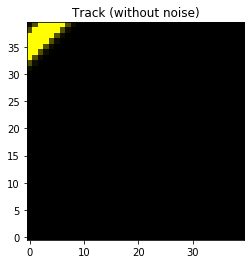

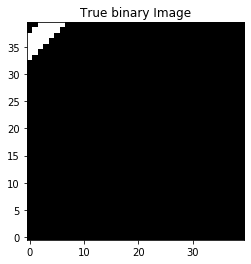

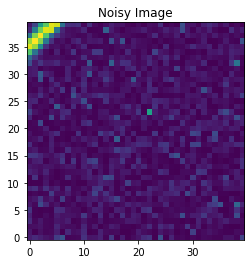

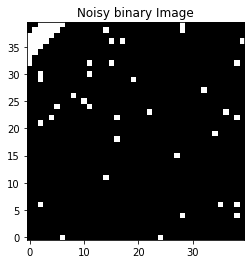

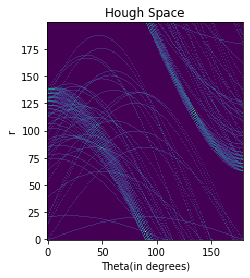

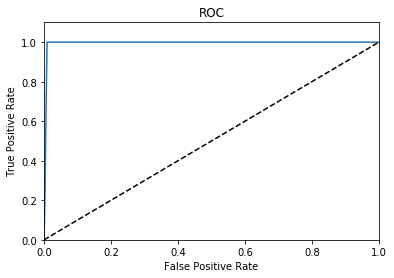

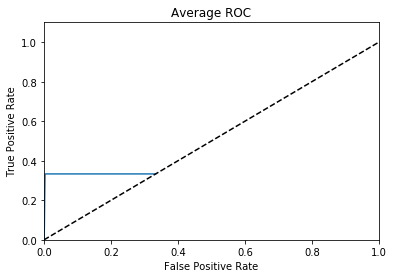

In [294]:
for N in range(1):
    
    #alpha=random.uniform(0.175,1.047) #The angle made by the generated line(between 30 and 60 degrees)
    alpha=0.785398
    print("Angle of track:",((180/pi)*alpha))
    sigma=1
    ybar=0
    xbar=35
    
    SNR=3
    th_true=0.3
    
    image=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_40.png",)
    pixel=get_image(image)#to get the track without any noise
    plt.imshow(pixel,origin='lower')
    plt.title('Track (without noise)')
    plt.show()
    
    pixel_gray=get_gray(pixel)#to get the grayscale of the track image
    
    binary_gray=get_binary_gray(pixel_gray,th_true)#to get the true track pixels
    plt.imshow(binary_gray,origin='lower')
    plt.title('True binary Image')
    plt.show()
   
    #print("Threshold for True Binary Spectrogram:",th_true)
    
    pixel_new=get_pixel_new(pixel_gray)#to introduce gaussian noise into the image
    plt.imshow(pixel_new,origin='lower')
    plt.title('Noisy Image')
    plt.show()
    
    th_noisy=np.mean(pixel_new)+3*sigma
    
    pixel_new_binary_img=get_noisy_binary_img(pixel_new,th_noisy)
    plt.imshow(pixel_new_binary_img,origin='lower')
    plt.title('Noisy binary Image')
    plt.show()
    
    #print("Threshold for Noisy Binary Spectrogram:",th_noisy)
    
    hough_space,points_x,points_y=get_hough_space(pixel_new,th_noisy)#hough space generator
    plt.imshow(hough_space,origin='lower')
    plt.xlabel('Theta(in degrees)')
    plt.ylabel('r')
    plt.title('Hough Space')
    plt.show()
    
    max_points=int(math.hypot(pixel.shape[0],pixel.shape[1]))
    
    if N==0:
        TPR_avg=np.zeros(shape=(max_points))
        FPR_avg=np.zeros(shape=(max_points))
    
    TPR,FPR=get_positive_rates(pixel_gray,hough_space,max_points,points_x,points_y,th_true)
    for k in range(max_points):
        TPR_avg[k]=TPR_avg[k]+TPR[k]
        FPR_avg[k]=FPR_avg[k]+FPR[k]
    
    print_ROC(TPR,FPR)
    
for k in range(max_points):
    TPR_avg[k]=TPR_avg[k]/3
    FPR_avg[k]=FPR_avg[k]/3
    
print_ROC_avg(TPR_avg,FPR_avg)

In [236]:
def get_image(image):
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            intensity=SNR*exp(-((((j-ybar))*cos(alpha))-(((i-xbar))*sin(alpha)))**2/(2*(sigma)**2))
            image[i,j]=(intensity,intensity,0)
    return image

In [237]:
def get_gray(pixel):
    pixel_gray=np.dot(pixel,[1,1,1])
    return pixel_gray

In [238]:
def get_binary_gray(pixel_gray,th_true):
    binary_gray=mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_40.png");
    
    for i in range(0,pixel_gray.shape[0]):
        for j in range(0,pixel_gray.shape[1]):
            if(pixel_gray[i,j]<(th_true*np.max(pixel_gray))):
                binary_gray[i,j]=(0,0,0)
    return binary_gray

In [254]:
def get_pixel_new(pixel_gray):
    noise=np.random.exponential(1.0,pixel_gray.shape)    
    pixel_new = SNR*pixel_gray+noise
    return pixel_new

In [240]:
def get_noisy_binary_img(pixel_new,th_noisy):
    
    noisy_binary_img= mpimg.imread(r"\Users\Kaustav Dutta\Desktop\white_40.png");
    
    for i in range(0,pixel_new.shape[0]):
        for j in range(0,pixel_new.shape[1]):
            if (pixel_new[i,j]<th_noisy):
                noisy_binary_img[i,j]=(0,0,0)
    return noisy_binary_img

In [280]:
def get_hough_space(pixel_new,th_noisy):

    x_max = pixel_new.shape[0]
    y_max = pixel_new.shape[1]

    theta_max = 1.0 *pi
    theta_min = 0.0

    r_min = 0.0
    r_max = math.hypot(x_max,y_max)

    r_dim = 200 
    theta_dim = 180

    count_coord=100
    points_x=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')
    points_y=np.zeros(shape=(r_dim,theta_dim,count_coord),dtype='int')

    hough_space = np.zeros(shape=(r_dim,theta_dim),dtype='int')

    for x in range(x_max):
        for y in range(y_max):
            if pixel_new[x,y]<th_noisy: continue
            for itheta in range(theta_dim):
                
                theta =(1.0*itheta*theta_max)/theta_dim
                r = x*cos(theta)+y*sin(theta)
                ir = int((r-r_min)/(r_max-r_min) * r_dim)
                points_x[ir,itheta,hough_space[ir,itheta]]=x
                points_y[ir,itheta,hough_space[ir,itheta]]=y            
                hough_space[ir,itheta] = hough_space[ir,itheta] + 1
            
    return hough_space,points_x,points_y             

In [242]:
def get_positive_rates(pixel_gray,hough_space,max_points,points_x,points_y,th_true):
    TPR=np.zeros(shape=(max_points))
    FPR=np.zeros(shape=(max_points))
    
    y_true=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
    for i in range(0,pixel_gray.shape[0]):
        for j in range(0,pixel_gray.shape[1]):
            if(pixel_gray[i,j]>=(np.max(pixel_gray)*th_true)):
                y_true[i,j]=1
    y_true=y_true.flatten()
            
    r_dim = 200 
    theta_dim = 180
    
    for thresh in range(0,max_points):   
        TP=0
        FP=0
        TN=0
        FN=0    
        y_pred=np.zeros(shape=(pixel_gray.shape[0],pixel_gray.shape[1]))
        
        if thresh==0:
            for k in range(pixel_gray.shape[0]):
                for l in range(pixel_gray.shape[1]):
                    y_pred[k,l]=1
        else:
            for i in range(hough_space.shape[0]):
                for j in range(hough_space.shape[1]):
                    if (hough_space[i,j]>=thresh):            
                        for l in range(hough_space[i,j]):
                            y_pred[points_x[i,j,l],points_y[i,j,l]]=1
                    
        y_pred=y_pred.flatten()
  
        for k in range(pixel_gray.shape[0]*pixel_gray.shape[1]):
            if(y_true[k]==1 and y_pred[k]==1):
                TP=TP+1
                    
            elif(y_true[k]==1 and y_pred[k]==0):
                FN=FN+1
                        
            elif(y_true[k]==0 and y_pred[k]==0):
                TN=TN+1
               
            elif(y_true[k]==0 and y_pred[k]==1):
                FP=FP+1 
        
        TPR[thresh]=TP/(TP+FN)
        FPR[thresh]=FP/(FP+TN)
        
    return TPR,FPR

In [243]:
def print_ROC(TPR,FPR):
    plt.plot(FPR,TPR)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC')
    plt.show()

In [244]:
def print_ROC_avg(TPR_avg,FPR_avg):
    plt.plot(FPR_avg,TPR_avg)
    plt.plot([0,1],[0,1],'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC')
    plt.show()